In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pickle

In [2]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [3]:
df_solar_satellite = pd.read_csv('../../1_data_analysis_and_preproc/intermediate/solar/solar_satellite_merged.csv')

In [4]:
df_solar_satellite.head()

,asset_id,read_at,ac_power,ac_voltage,ac_current,dc_power,dc_voltage,dc_current,farm,satellite_id,global_tilted_irradiance,global_horizontal_irradiance,temperature,cloud_cover
0,11,2022-01-01 08:10:00,82.0,235.0,0.298,60.6247,275.567,0.220,1,1,2.0,2.0,12.3,46.1
1,13,2022-01-01 08:10:00,124.0,235.0,0.450,134.7940,469.667,0.287,1,1,2.0,2.0,12.3,46.1
2,14,2022-01-01 08:10:00,269.0,235.0,0.696,280.0100,510.967,0.548,1,1,2.0,2.0,12.3,46.1
3,15,2022-01-01 08:10:00,195.0,235.0,0.549,201.4470,491.333,0.410,1,1,2.0,2.0,12.3,46.1
4,17,2022-01-01 08:10:00,224.0,234.0,0.616,232.5800,483.533,0.481,1,1,2.0,2.0,12.3,46.1


In [5]:
np.random.seed(10)

# Define the desired subset size per asset (adjust as needed)
subset_size_percentage = 0.1  # Adjust as needed

# Get the unique asset identifiers from the original DataFrame
unique_assets = df_solar_satellite['asset_id'].unique()

# Find the minimum number of rows among all assets
min_rows = min(df_solar_satellite['asset_id'].value_counts())

# Calculate the subset size based on the minimum number of rows
subset_size = int(subset_size_percentage * min_rows)

# Initialize an empty list to store the sampled data
subset_data = []

# Iterate over each asset, sample rows, and append to subset_data
for asset in unique_assets:
    # Filter the DataFrame for the current asset
    asset_df = df_solar_satellite[df_solar_satellite['asset_id'] == asset]
    
    # Sample rows from the asset DataFrame
    sampled_group = asset_df.sample(n=subset_size, replace=False)
    subset_data.append(sampled_group)

# Concatenate the sampled data from all assets into a single DataFrame
df_subset = pd.concat(subset_data)


In [6]:
df_subset['asset_id'].nunique()

77

In [7]:
len(df_subset)

46046

In [8]:
df_subset = df_subset.reset_index(drop=True)

the variables to include for the model should be dc_power, dc_voltage, dc_current, temperature and cloud_cover, as global_tilted_irradiance and global_horizontal_irradiance have very high correlation with other variables and keeping them, would be reductant

however, in the time series clustering, we'll want to do one variable at a time and then all of them.

In [9]:
X = df_subset[['asset_id','read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover']]
X.head()

,asset_id,read_at,dc_power,dc_voltage,dc_current,temperature,cloud_cover
0,11,2023-11-01 10:40:00,1129.83,317.367,3.560,16.0,74.0
1,11,2023-04-28 10:40:00,4183.51,290.300,14.411,22.0,4.0
2,11,2023-02-26 12:00:00,5973.22,294.567,20.278,14.0,0.0
3,11,2022-06-28 08:00:00,2776.43,314.967,8.815,16.0,0.0
4,11,2023-02-24 16:20:00,3352.19,325.867,10.287,11.0,10.0


In [10]:
X.dtypes

asset_id         int64
read_at         object
dc_power       float64
dc_voltage     float64
dc_current     float64
temperature    float64
cloud_cover    float64
dtype: object

In [11]:
X['read_at'] = pd.to_datetime(X['read_at'])

/tmp/ipykernel_19508/2166665197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['read_at'] = pd.to_datetime(X['read_at'])


In [12]:
X['read_at'] = X['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)

/tmp/ipykernel_19508/3417196857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['read_at'] = X['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)


In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46046 entries, 0 to 46045
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   asset_id     46046 non-null  int64  
 1   read_at      46046 non-null  float64
 2   dc_power     46046 non-null  float64
 3   dc_voltage   46046 non-null  float64
 4   dc_current   46046 non-null  float64
 5   temperature  46046 non-null  float64
 6   cloud_cover  46046 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 2.5 MB


In [14]:
X = X.astype(np.float32)

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46046 entries, 0 to 46045
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   asset_id     46046 non-null  float32
 1   read_at      46046 non-null  float32
 2   dc_power     46046 non-null  float32
 3   dc_voltage   46046 non-null  float32
 4   dc_current   46046 non-null  float32
 5   temperature  46046 non-null  float32
 6   cloud_cover  46046 non-null  float32
dtypes: float32(7)
memory usage: 1.2 MB


In [16]:
X_grouped = X.groupby('asset_id')

In [17]:
def zoom_in_plot(X_train, y_pred, km, sz, title:str):
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 4, width_ratios=[5, 1, 3, 1], height_ratios=[1, 1, 1])

    for yi in range(3):
        # Main plot with more width
        ax = plt.subplot(gs[yi, 0])
        for xx in X_train[y_pred == yi]:  
            ax.plot(xx.ravel(), "k-", alpha=0.2)
        ax.plot(km.cluster_centers_[yi].ravel(), "r-")
        ax.set_xlim(0, sz)
        ax.set_ylim(-4, 4)
        ax.text(0.55, 0.85, 'Cluster %d' % (yi + 1), transform=ax.transAxes)
        if yi == 0:
            ax.set_title(f"{title} $k$-means")

        # Zoomed-in plot
        axins = plt.subplot(gs[yi, 2])
        for xx in X_train[y_pred == yi]:  
            axins.plot(xx.ravel(), "k-", alpha=0.2)
        axins.plot(km.cluster_centers_[yi].ravel(), "r-")
        axins.set_xlim(200, 220)
        axins.set_ylim(-3, 3)
        mark_inset(ax, axins, loc1=2, loc2=3, fc="None", ec="g")

    # Adjust spacing between the two plots in the same row
    plt.subplots_adjust(wspace=0)

    # plt.tight_layout()
    plt.show()

## Time Series Clustering with all important variables

https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py

### Euclidean k-Means

In [18]:
def clustering_score(estimator, X, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    labels = estimator.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    final_score = silhouette_weight * silhouette + davies_bouldin_weight * davies_bouldin
    return final_score

In [19]:
X_train = X.loc[:,'read_at':]

In [20]:
seed = 0

In [21]:
# Define the parameter grid
param_grid = {
    'n_clusters': [2, 3, 4, 5, 10],
}

euc_k_means_clust = TimeSeriesKMeans(verbose=False, random_state=seed)

# Initialize GridSearchCV
grid_search = GridSearchCV(euc_k_means_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[CV] END .......................................n_clusters=2; total time= 2.3min
[CV] END .......................................n_clusters=2; total time= 2.4min
[CV] END .......................................n_clusters=3; total time= 2.9min
[CV] END .......................................n_clusters=3; total time= 3.0min
[CV] END .......................................n_clusters=4; total time= 7.0min
[CV] END .......................................n_clusters=4; total time= 7.0min
[CV] END .......................................n_clusters=5; total time= 9.2min
[CV] END .......................................n_clusters=5; total time= 9.3min
[CV] END ......................................n_clusters=10; total time= 7.2min
[CV] END ......................................n_clusters=10; total time= 7.3min


GridSearchCV(cv=2, estimator=TimeSeriesKMeans(random_state=0, verbose=False),
             n_jobs=-1, param_grid={'n_clusters': [2, 3, 4, 5, 10]},
             scoring=<function clustering_score at 0x7ff64f13efc0>, verbose=2)

In [22]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,62.597421,6.279531,79.792325,4.718771,2,{'n_clusters': 2},0.561381,0.565845,0.563613,0.002232,1
1,76.036546,36.090118,100.819687,40.053984,3,{'n_clusters': 3},0.544865,0.542302,0.543583,0.001282,2
2,216.154179,9.803566,204.458036,7.903776,4,{'n_clusters': 4},0.543337,0.540731,0.542034,0.001303,3
3,295.186281,38.376500,257.086448,41.548768,5,{'n_clusters': 5},0.540574,0.534474,0.537524,0.003050,4
4,239.152751,15.895186,195.646056,11.986042,10,{'n_clusters': 10},0.534195,0.531477,0.532836,0.001359,5


In [23]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Clustering Score:", best_score)

Best Parameters: {'n_clusters': 2}
Best Clustering Score: 0.5636130375973387


In [21]:
# Grouping by 'asset_id' and storing each group as an array
grouped_arrays_all = [group[['read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover']].values \
                    for _, group in X.groupby('asset_id')]

In [22]:
X_train = grouped_arrays_all

In [26]:
seed = 42

In [23]:
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

sz = X_train.shape[1]

using 3 clusters as its the second best clustering partition and then the can be more distributed

Euclidean k-means
6763.598 --> 3441.686 --> 3441.686 --> 


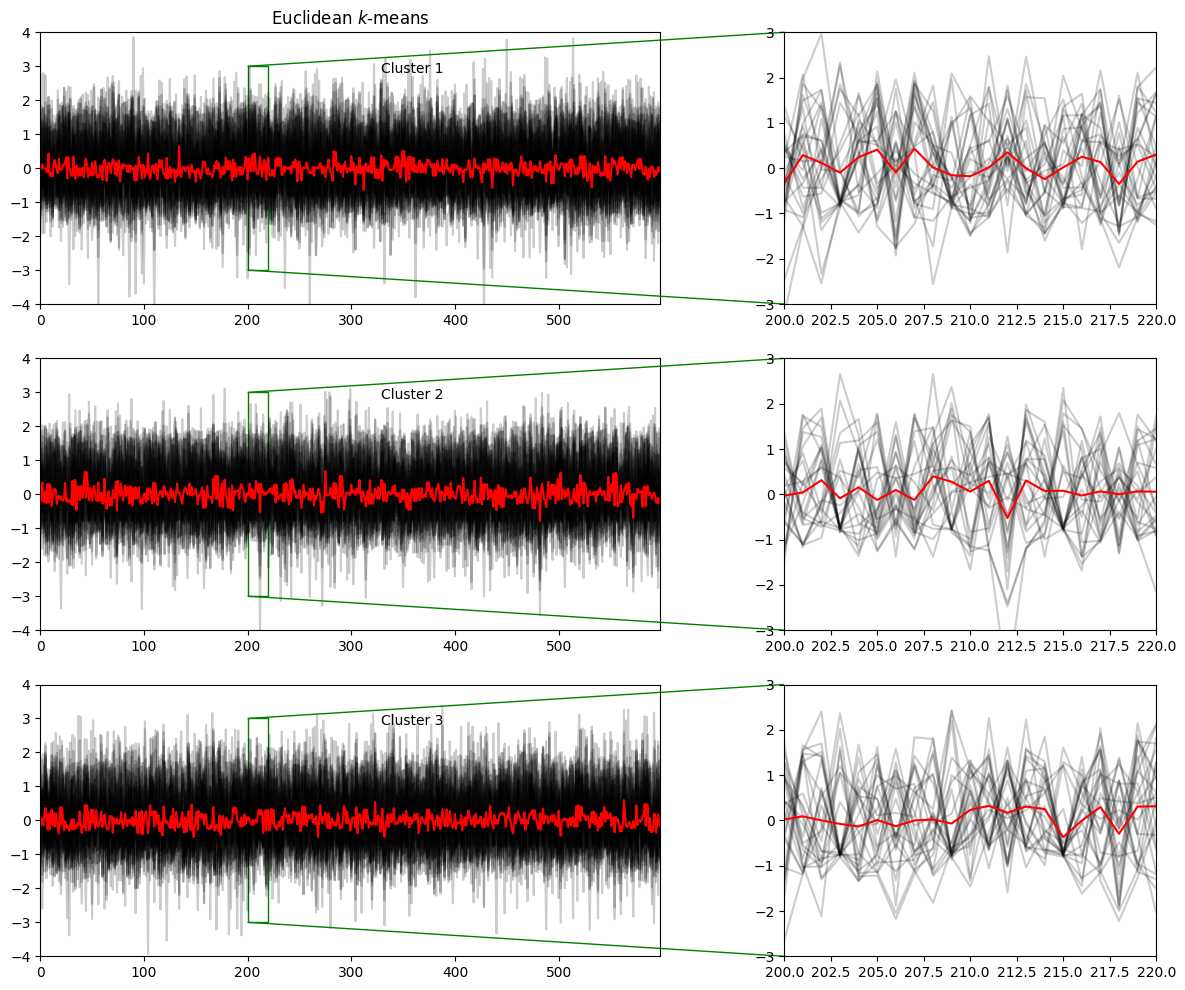

In [28]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred_euclidean = km.fit_predict(X_train)

zoom_in_plot(X_train, y_pred_euclidean, km, sz, 'Euclidean')


In [29]:
with open('intermediate_with_out/euclidean_solar.pickle', 'wb') as f:
    pickle.dump(km, f)

In [46]:
assets_per_cluster_euclidean = pd.DataFrame()

assets_per_cluster_euclidean['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_euclidean['cluster_label'] = y_pred_euclidean

In [31]:
assets_clusters = assets_per_cluster_euclidean.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [1, 4, 5, 6, 12, 14, 17, 20, 26, 28, 29, 30, 34, 35, 39, 40, 41, 43, 44, 46, 47, 55, 62, 66, 68, 69, 70]
Cluster 1: [2, 7, 10, 13, 15, 18, 21, 22, 27, 31, 36, 42, 45, 49, 50, 53, 57, 60, 61, 63, 72, 73, 74, 76]
Cluster 2: [0, 3, 8, 9, 11, 16, 19, 23, 24, 25, 32, 33, 37, 38, 48, 51, 52, 54, 56, 58, 59, 64, 65, 67, 71, 75]


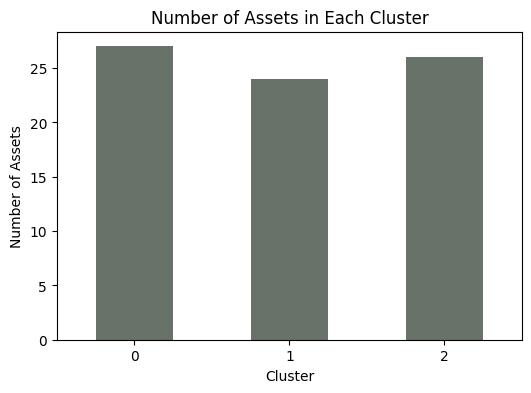

In [32]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_euclidean['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [33]:
asset_per_cluster = pd.DataFrame(columns=['Metric', 'Cluster 0', 'Cluster 1', 'Cluster 2'])

for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[0, column_name] = count

asset_per_cluster.loc[0, 'Metric'] = 'Euclidean'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,27,24,26


In [45]:
with open('intermediate_with_out/euclidean_solar.pickle', 'rb') as f:
    km = pickle.load(f)

y_pred_euclidean = km.predict(X_train)

In [47]:
merged_df = df_solar_satellite.merge(assets_per_cluster_euclidean, on='asset_id', how='left')

In [48]:
merged_df.to_csv('intermediate_with_out/results_raw_solar_euclidean.csv', index = False)

### DBA k-Means

In [34]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)

y_pred_DBA = dba_km.fit_predict(X_train)

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


3915.196 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


2538.727 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


2538.727 --> 
Init 2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


3927.985 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s


2539.962 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s


2539.962 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s


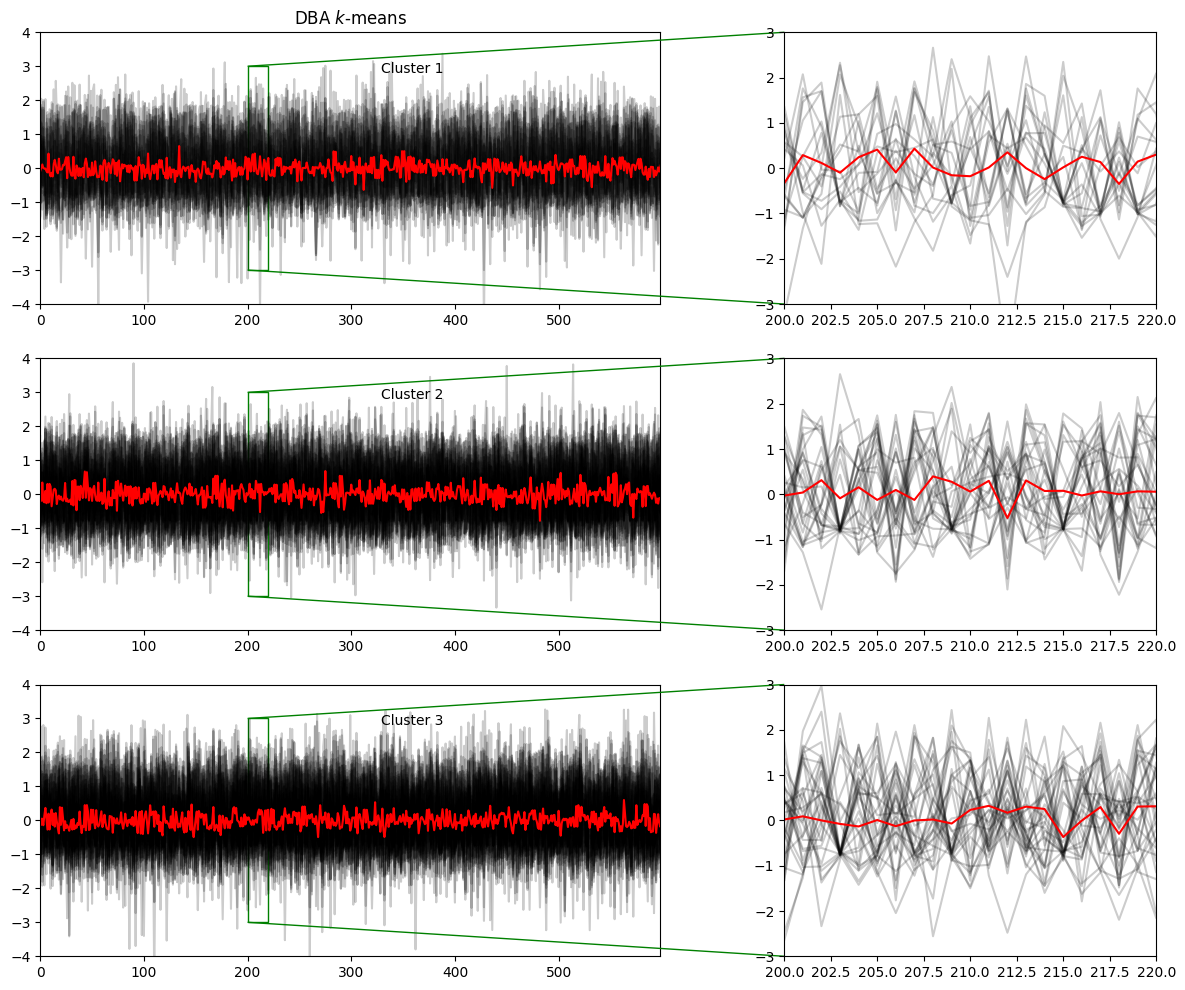

In [35]:
zoom_in_plot(X_train, y_pred_DBA, km, sz, 'DBA')

In [36]:
with open('intermediate_with_out/DBA_solar.pickle', 'wb') as f:
    pickle.dump(dba_km, f)

In [42]:
assets_per_cluster_dba = pd.DataFrame()

assets_per_cluster_dba['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_dba['cluster_label'] = y_pred_DBA

In [38]:
assets_clusters = assets_per_cluster_dba.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [15, 18, 22, 26, 31, 33, 36, 37, 38, 41, 42, 44, 50, 51, 53, 66, 73, 74]
Cluster 1: [0, 2, 3, 4, 5, 6, 7, 8, 11, 13, 14, 16, 21, 23, 25, 45, 46, 47, 48, 52, 54, 55, 57, 60, 61, 62, 63]
Cluster 2: [1, 9, 10, 12, 17, 19, 20, 24, 27, 28, 29, 30, 32, 34, 35, 39, 40, 43, 49, 56, 58, 59, 64, 65, 67, 68, 69, 70, 71, 72, 75, 76]


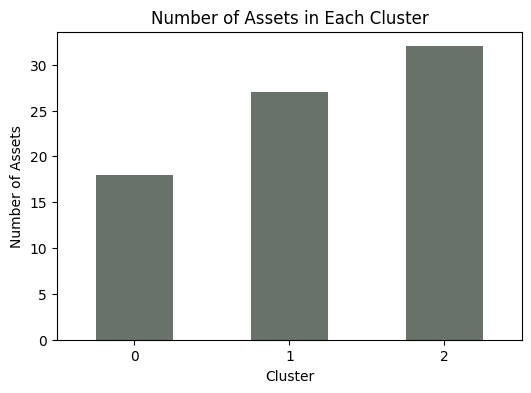

In [39]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_dba['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [40]:
for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[1, column_name] = count

asset_per_cluster.loc[1, 'Metric'] = 'DBA'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,27,24,26
1,DBA,18,27,32


In [40]:
with open('intermediate_with_out/DBA_solar.pickle', 'rb') as f:
    dba_km = pickle.load(f)

y_pred_DBA = dba_km.predict(X_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.5s


In [43]:
merged_df = df_solar_satellite.merge(assets_per_cluster_dba, on='asset_id', how='left')

In [44]:
merged_df.to_csv('intermediate_with_out/results_raw_solar_dba.csv', index = False)

## Soft DTW k-means

In [41]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
                           
y_pred_soft_dtw = sdtw_km.fit_predict(X_train)

Soft-DTW k-means
15971971.518 --> 6423145.484 --> 6415428.032 --> 6413538.370 --> 6412721.783 --> 6412472.712 --> 6412436.266 --> 6412435.850 --> 6412367.661 --> 6412257.841 --> 6412113.387 --> 6411600.979 --> 6411558.609 --> 6411558.419 --> 6411556.864 --> 6411556.946 --> 6411556.756 --> 6411556.814 --> 6411556.801 --> 6411556.805 --> 6411556.805 --> 


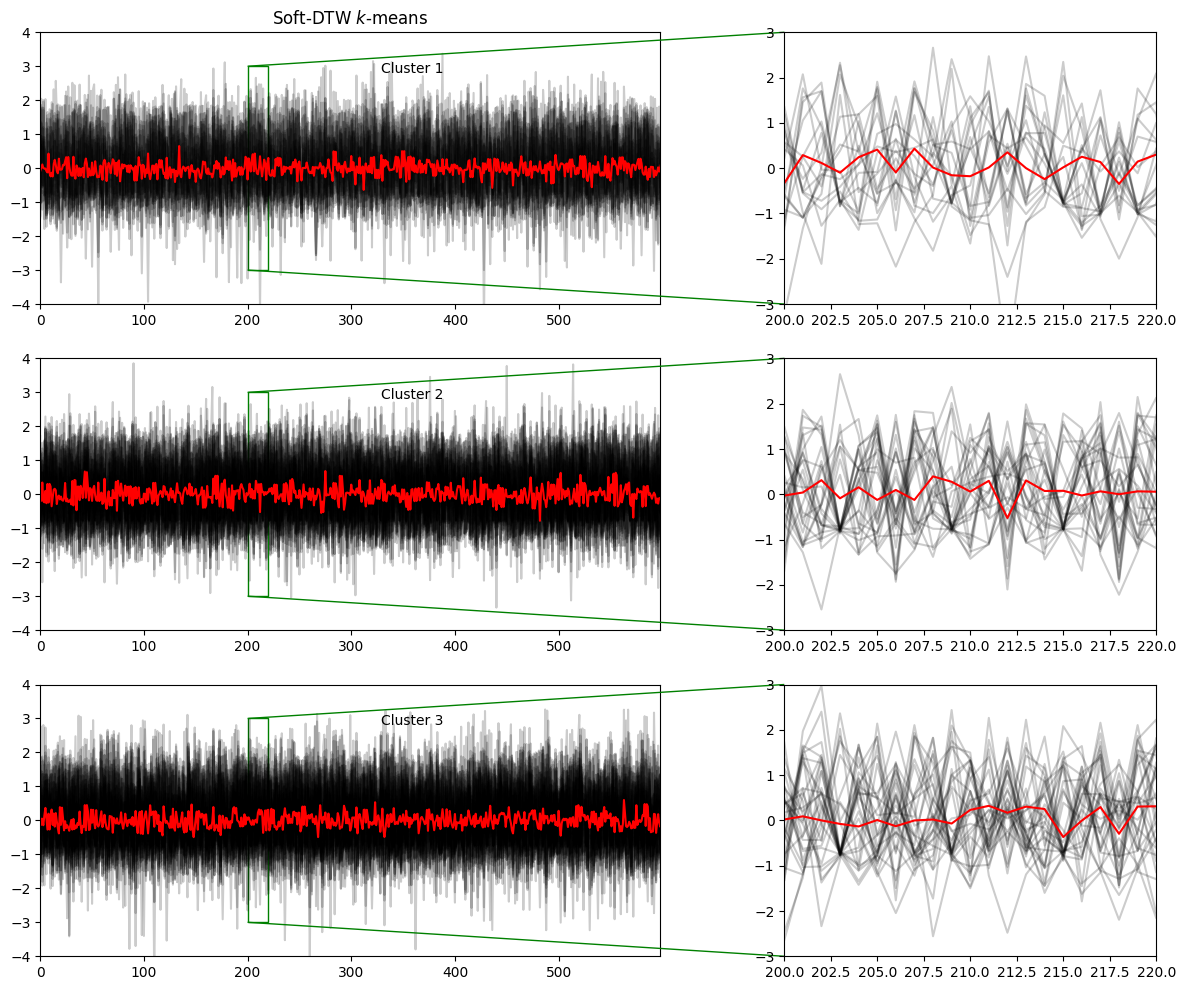

In [42]:
zoom_in_plot(X_train, y_pred_soft_dtw, km, sz, 'Soft-DTW')

In [43]:
with open('intermediate_with_out/SDTW_solar.pickle', 'wb') as f:
    pickle.dump(sdtw_km, f)

In [27]:
with open('intermediate_with_out/SDTW_solar.pickle', 'rb') as f:
    soft_dtw = pickle.load(f)

y_pred_soft_dtw = soft_dtw.predict(X_train)

In [30]:
assets_per_cluster_soft_dtw = pd.DataFrame()

assets_per_cluster_soft_dtw['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_soft_dtw['cluster_label'] = y_pred_soft_dtw

In [45]:
assets_clusters = assets_per_cluster_soft_dtw.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [15, 18, 22, 26, 31, 33, 36, 37, 38, 41, 42, 44, 50, 51, 53, 66, 73, 74]
Cluster 1: [0, 2, 3, 4, 5, 6, 7, 8, 11, 13, 14, 16, 21, 23, 25, 45, 46, 47, 48, 52, 54, 55, 57, 60, 61, 62, 63]
Cluster 2: [1, 9, 10, 12, 17, 19, 20, 24, 27, 28, 29, 30, 32, 34, 35, 39, 40, 43, 49, 56, 58, 59, 64, 65, 67, 68, 69, 70, 71, 72, 75, 76]


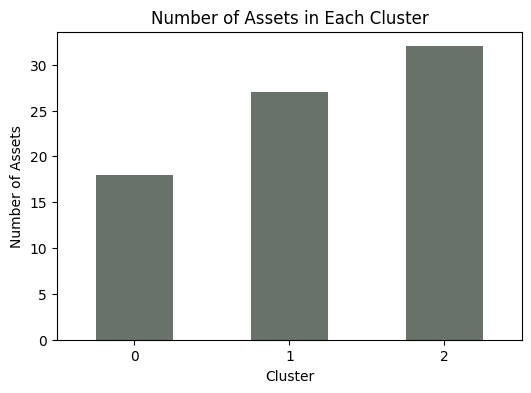

In [46]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_soft_dtw['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [47]:
for cluster_label, count in cluster_counts.items():
    column_name = f'Cluster {cluster_label}'  # Generate column name dynamically
    asset_per_cluster.loc[2, column_name] = count

asset_per_cluster.loc[2, 'Metric'] = 'Soft DTW'

asset_per_cluster

,Metric,Cluster 0,Cluster 1,Cluster 2
0,Euclidean,27,24,26
1,DBA,18,27,32
2,Soft DTW,18,27,32


In [31]:
merged_df = df_solar_satellite.merge(assets_per_cluster_soft_dtw, on='asset_id', how='left')

In [39]:
merged_df.to_csv('intermediate_with_out/results_raw_solar_soft_dtw.csv', index = False)